# Hearthstone example

**Source:** [hsreplay](hsreplay.net) (downloaded May 3rd, 2021). 

## Helpful functions

In [88]:
import copy 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import linprog

import nashpy

# this module contains the data
import hst 

In [89]:
def solve_zerosum_with_linprog(U):
    '''solve_zerosum_with_linprog(): Solve a zero sum game using linear programming
    
        INPUT: U (k*k square matrix), payoffs in zero sum game (opponent gets -U.T)
        OUTPUT: alpha (k-vector) of probability weights for each action (the symmetric equilibrium)
    '''
    k, k2 = U.shape
    assert k == k2, f'Input matrix must be square, got {k}*{k2}'

    oo = np.zeros((1,k))
    ii = np.ones((1,k))

    # objective: c = [-1, 0, 0, ..., 0]
    c = np.insert(oo, 0, -1.0) # insert -1 in front (pos = index 0)
    
    # inequality constraints A*x <= b
    # top = [ 1 ...
    #         1 -1*A.Tl
    #         1  ...  ]
    # bot = [ 0 -1 0 0 
    #         0 0 -1 0 
    #         0 0 0 -1]
    top  = np.hstack( (ii.T, -1*U.T) )
    bot  = np.hstack( (oo.T, -1*np.eye(k)) )
    A_ub = np.vstack((top, bot))
    
    b_ub = np.zeros((1, 2*k))
    b_ub = np.matrix(b_ub)
    
    # contraints Ax = b
    # A = [0, 1, 1, ..., 1]
    A = np.matrix(np.hstack((0, np.ones((k,)))))
    b = 1.0 # just one condition so scalar 

    # v and alpha must be non-negative
    bounds = [(0,None) for i in range(k+1)]

    # call the solver
    sol = linprog(c=c, A_ub=A_ub, b_ub=b_ub, A_eq=A, b_eq=b)
    
    # remove the first element: just return the Nash EQ 
    alpha = sol.x[1:]
    return alpha

# Read data

In [90]:
dat, playrates = hst.read_data()

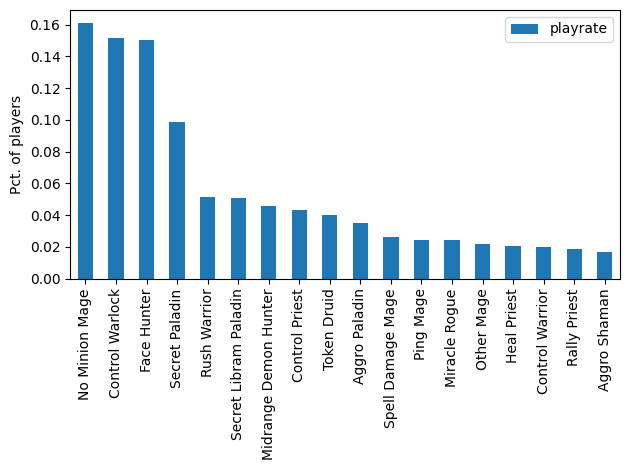

In [91]:
ax=playrates.plot.bar(ylabel='Pct. of players'); 
ax.set_xticklabels(playrates.deck); 
plt.tight_layout(); 

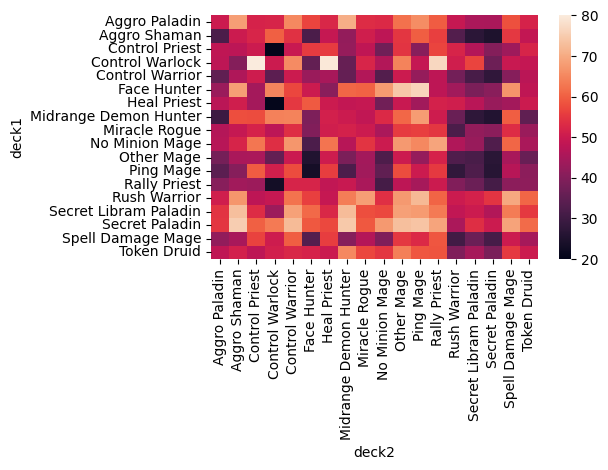

In [92]:
rows = dat.index.get_level_values('deck1')
cols = dat.columns
decks = rows
sns.heatmap(dat, xticklabels=cols, yticklabels=rows); 
plt.tight_layout(); 

In [93]:
decks

Index(['Aggro Paladin', 'Aggro Shaman', 'Control Priest', 'Control Warlock',
       'Control Warrior', 'Face Hunter', 'Heal Priest',
       'Midrange Demon Hunter', 'Miracle Rogue', 'No Minion Mage',
       'Other Mage', 'Ping Mage', 'Rally Priest', 'Rush Warrior',
       'Secret Libram Paladin', 'Secret Paladin', 'Spell Damage Mage',
       'Token Druid'],
      dtype='object', name='deck1')

In [94]:
U1 = dat.values # numpy array 

***...continue from here...***

**Utilizing IESDS to exclude strictly dominanted strategies**

In [95]:

def check_dominance_for_1(U1):
    '''
    Input: 
        U1: (na1*na2) numpy array of utilities for the row player
    Returns: 
        dominated_actions: list of integers (or empty) for the dominated actions
    '''
    na1,na2 = U1.shape
    dominated_actions = []
    for a in range(na1):
        for a_ in range(na1): 
            if a_ == a: 
                continue
            if (U1[a, :] < U1[a_, :]).all():
                print(f'a={a} is strictly dominated by a={a_}')
                dominated_actions.append(a)
                break
    return dominated_actions


def IESDS(U1_in, U2_in, maxit=100): 
    U1 = U1_in.copy()
    U2 = U2_in.copy()
    na1,na2 = U1.shape
    aa1 = np.arange(na1) 
    aa2 = np.arange(na2)
    dominated_strategies = []
    
    for it in range(maxit): 
        d = False
        
        # check for player 1
        a_del = check_dominance_for_1(U1)
        dominated_strategies.extend(a_del)
        a_keep = [a for a in range(U1.shape[0]) if a not in a_del]
        aa1 = aa1[a_keep]
        U1 = U1[a_keep, :]
        U2 = U2[a_keep, :]
        
        if len(a_del) > 0: 
            d = True   
        
        # check for player 2 
        a_del = check_dominance_for_1(U2.T)
        a_keep = [a for a in range(U2.shape[1]) if a not in a_del]
        aa2 = aa2[a_keep] 
        U1 = U1[:, a_keep]
        U2 = U2[:, a_keep]
        
        if len(a_del) > 0: 
            d = True    
            
        if not d: 
            print(f'No further strategies to delete after {it} iterations')
            break 
        
    assert it < maxit, f'Algorithm did not converge'
    
    return U1, U2, aa1, aa2, dominated_strategies

#By symmetry:
U2 = U1.T
U1_new, U2_new, aa1, aa2, dominated_strategies = IESDS(U1, U2)



mapped_decks = [decks[i] for i in dominated_strategies]
print(f'Dominated strategies: {mapped_decks}')



a=1 is strictly dominated by a=15
a=4 is strictly dominated by a=0
a=8 is strictly dominated by a=0
a=10 is strictly dominated by a=0
a=11 is strictly dominated by a=9
a=12 is strictly dominated by a=0
a=16 is strictly dominated by a=15
a=17 is strictly dominated by a=15
a=1 is strictly dominated by a=15
a=4 is strictly dominated by a=0
a=8 is strictly dominated by a=0
a=10 is strictly dominated by a=0
a=11 is strictly dominated by a=9
a=12 is strictly dominated by a=0
a=16 is strictly dominated by a=15
a=17 is strictly dominated by a=15
No further strategies to delete after 1 iterations
Dominated strategies: ['Aggro Shaman', 'Control Warrior', 'Miracle Rogue', 'Other Mage', 'Ping Mage', 'Rally Priest', 'Spell Damage Mage', 'Token Druid']


**Calculation of K' order rationality**

In [96]:
def k_t_start(t, U):
    '''
    Input: 
        t: number of iterations
        U1: (na1*na2) numpy array of utilities for the row player
        U2: (na1*na2) numpy array of utilities for the column player
    Returns: 
        Array of len T, of optimal strategies for player 1 for the given k order.
    '''
    strat_amount = len(U[0])
    print(f'Initial strategies: {strat_amount}')
    
    #initialize the strategies distribution as uniform
    alpha = np.ones(strat_amount)/strat_amount
    best_strat = []
    print(f'Initial alpha shape: {alpha.shape}')
    for i in range(t):
        EU1 = U @ alpha
        best_strat.append(np.argmax(EU1))
        #print the top 3 strategies and there expected utility
        print(f'Best strategy {decks[np.argmax(EU1)]}. Top 3 strategies in Iteration {i+1}: {[decks[i] for i in np.argsort(EU1)[::-1][:3]]} with EU: {np.sort(EU1)[::-1][:3]}')
    
        #update the alpha
        alpha = np.zeros(strat_amount)
        alpha[np.argmax(EU1)] = 1
    return best_strat
        
    
    
k_t_start(20, U1_new)

Initial strategies: 10
Initial alpha shape: (10,)
Best strategy No Minion Mage. Top 3 strategies in Iteration 1: ['No Minion Mage', 'Miracle Rogue', 'Midrange Demon Hunter'] with EU: [58.529 53.993 52.649]
Best strategy Midrange Demon Hunter. Top 3 strategies in Iteration 2: ['Midrange Demon Hunter', 'No Minion Mage', 'Miracle Rogue'] with EU: [54.49 50.   46.37]
Best strategy Aggro Shaman. Top 3 strategies in Iteration 3: ['Aggro Shaman', 'Control Priest', 'Control Warrior'] with EU: [52.08 50.9  50.8 ]
Best strategy Control Priest. Top 3 strategies in Iteration 4: ['Control Priest', 'Heal Priest', 'No Minion Mage'] with EU: [80.01 62.81 60.03]
Best strategy Control Warlock. Top 3 strategies in Iteration 5: ['Control Warlock', 'Face Hunter', 'No Minion Mage'] with EU: [64.54 64.21 63.18]
Best strategy Miracle Rogue. Top 3 strategies in Iteration 6: ['Miracle Rogue', 'Control Warrior', 'No Minion Mage'] with EU: [61.07 59.27 58.99]
Best strategy Control Priest. Top 3 strategies in Iter

[9, 7, 1, 2, 3, 8, 2, 3, 8, 2, 3, 8, 2, 3, 8, 2, 3, 8, 2, 3]

**Udregning af Arnes bedste strategi**

In [97]:
playrates = np.array(playrates)

#remove the strategie names
playrates = playrates[:,1]


array([0.16118544454170317, 0.15130674002751035, 0.15030636488683258,
       0.09866199824934352, 0.051644366637489066, 0.051019132174565475,
       0.04589220957859198, 0.04301613104914344, 0.03988995873452546,
       0.03513817681630612, 0.026259847442791053, 0.024259097161435542,
       0.024134050268850824, 0.021883206202325877, 0.020257596598724528,
       0.01963236213580093, 0.018631986995123175, 0.016881330498937107],
      dtype=object)

In [99]:
EU1 = U1 @ playrates
EU1
argmax = np.argmax(EU1)
print(f'Best strategy: {decks[argmax]} with EU: {EU1[argmax]}')

Best strategy: Secret Paladin with EU: 63.549697386519945


**Caclulation of NE with linprog**

In [121]:
result = solve_zerosum_with_linprog(U1)
#find the index of the non zero results and map them into decks
result = np.array(result)
print(result)
result = np.where(result > 0)[0]
result = [decks[i] for i in result]

print(f'Nash Equilibrium: {result}')    


Nash Equilibrium: ['Control Warlock', 'Rush Warrior', 'Secret Paladin']


**Calculation of NE with fictious play**

Strategy for Aggro Paladin: 0.0
Strategy for Control Priest: 0.002002002002002002
Strategy for Control Warlock: 0.23423423423423423
Strategy for Face Hunter: 0.001001001001001001
Strategy for Heal Priest: 0.0
Strategy for Midrange Demon Hunter: 0.0
Strategy for No Minion Mage: 0.0
Strategy for Rush Warrior: 0.7097097097097097
Strategy for Secret Libram Paladin: 0.0
Strategy for Secret Paladin: 0.05305305305305305


/var/folders/0s/0fmqq8v139jbm78b3k7cf_3h0000gn/T/ipykernel_17350/1560711664.py:3: RuntimeWarning: invalid value encountered in divide
  probabilities = [row_play_counts / np.sum(row_play_counts) for row_play_counts, col_play_counts in play_counts]


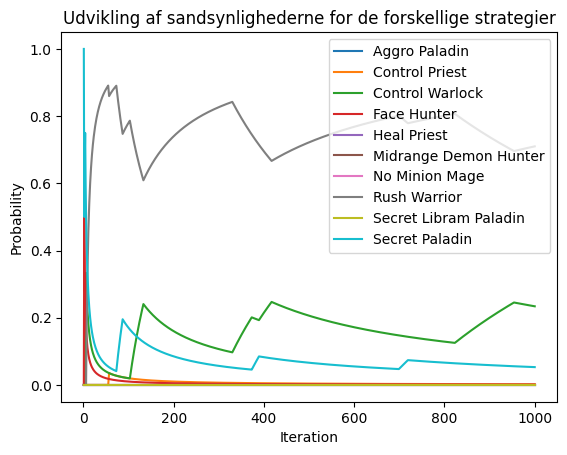

In [130]:
play_counts  = nashpy.Game(U1_new, -U1_new).fictitious_play(1000)

probabilities = [row_play_counts / np.sum(row_play_counts) for row_play_counts, col_play_counts in play_counts]

deck_names = [decks[i] for i in aa1]

for number, strategy in enumerate(zip(*probabilities)):
    print(f"Strategy for {deck_names[number]}: {strategy[999]}")
    plt.plot(strategy, label=f"{deck_names[number]}")  
plt.xlabel("Iteration")  
plt.ylabel("Probability")  
plt.title("Udvikling af sandsynlighederne for de forskellige strategier")  
plt.legend()  

In [126]:
[decks[i] for i in aa1]

['Aggro Paladin',
 'Control Priest',
 'Control Warlock',
 'Face Hunter',
 'Heal Priest',
 'Midrange Demon Hunter',
 'No Minion Mage',
 'Rush Warrior',
 'Secret Libram Paladin',
 'Secret Paladin']